# 26: Fisher Information Overlap Analysis

Theoretical analysis of why parameter-space unlearning fails for generative models.

**Core argument:** VAE decoders share parameters across all output dimensions, so
forget-set influence (measured by Fisher information) overlaps heavily with retain-set
influence. Classifiers concentrate forget-class influence in class-specific output weights.

This notebook:
1. Computes diagonal Fisher for forget and retain sets on the VAE
2. Trains a linear classifier on frozen VAE latents
3. Computes classifier Fisher for comparison
4. Generates figures for the paper

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

from vae import VAE

matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 0.8

OUTPUTS = Path('../outputs')
FIGURES = Path('../figures')
FIGURES.mkdir(exist_ok=True)
(OUTPUTS / 'p6').mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## 1. Load data and model

In [2]:
# Load processed data
adata = sc.read_h5ad('../data/adata_processed.h5ad')
print(f'Data: {adata.shape}')

# Load splits
with open(OUTPUTS / 'p1' / 'split_structured.json') as f:
    split = json.load(f)
forget_idx = split['forget_indices']
retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']
print(f'Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}')

# Load baseline model
ckpt = torch.load(OUTPUTS / 'p1' / 'baseline' / 'best_model.pt',
                   map_location=device, weights_only=False)
config = ckpt['config']
vae_args = {k: v for k, v in config.items()
            if k in ['input_dim', 'latent_dim', 'hidden_dims', 'likelihood',
                      'dropout', 'use_layer_norm']}
model = VAE(**vae_args).to(device)
model.load_state_dict(ckpt['model_state_dict'])
model.train()  # Need gradients for Fisher
print(f'Model: {sum(p.numel() for p in model.parameters()):,} params')

Data: (33088, 2000)
Forget: 30, Retain: 28094, Unseen: 4964
Model: 7,349,984 params


## 2. Compute VAE Fisher diagonals

In [3]:
class AnnDataDataset(Dataset):
    def __init__(self, adata, indices):
        self.adata = adata
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        i = self.indices[idx]
        row = self.adata.X[i]
        x = torch.FloatTensor(
            row.toarray().flatten() if hasattr(row, 'toarray') else np.asarray(row).flatten()
        )
        library_size = torch.FloatTensor([x.sum().item()])
        return x, library_size


def compute_fisher_diagonal(model, dataloader, device, damping=1e-8):
    """Diagonal Fisher: F_ii = E[(dL/dtheta_i)^2]."""
    model.train()
    fisher = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            fisher[name] = torch.zeros_like(param.data)
    n_samples = 0
    for x_batch, lib_batch in dataloader:
        x_batch, lib_batch = x_batch.to(device), lib_batch.to(device)
        model.zero_grad()
        mu, logvar = model.encode(x_batch)
        z = model.reparameterize(mu, logvar)
        if model.likelihood == 'nb':
            mean, dispersion = model.decode(z, lib_batch)
            recon_loss = nn.functional.mse_loss(mean, x_batch, reduction='sum')
        else:
            recon_mu, recon_logvar = model.decode(z)
            recon_loss = 0.5 * (recon_logvar + ((x_batch - recon_mu)**2)/torch.exp(recon_logvar) + np.log(2*np.pi)).sum()
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                fisher[name] += param.grad.data ** 2
        n_samples += x_batch.size(0)
    for name in fisher:
        fisher[name] /= n_samples
        fisher[name] += damping
    model.eval()
    return fisher, n_samples

In [4]:
forget_ds = AnnDataDataset(adata, forget_idx)
retain_ds = AnnDataDataset(adata, retain_idx)
forget_loader = DataLoader(forget_ds, batch_size=128, shuffle=False)
retain_loader = DataLoader(retain_ds, batch_size=256, shuffle=False)

print('Computing forget-set Fisher...')
fisher_forget, n_f = compute_fisher_diagonal(model, forget_loader, device)
print(f'  {n_f} samples')

print('Computing retain-set Fisher...')
fisher_retain, n_r = compute_fisher_diagonal(model, retain_loader, device)
print(f'  {n_r} samples')

# Save tensors for reuse
torch.save({'fisher_forget': fisher_forget, 'fisher_retain': fisher_retain},
           OUTPUTS / 'p6' / 'fisher_tensors.pt')
print('Saved.')

Computing forget-set Fisher...
  30 samples
Computing retain-set Fisher...
  28094 samples
Saved.


## 3. VAE Fisher overlap metrics

In [5]:
def cosine_sim(a, b):
    return (torch.dot(a, b) / (torch.norm(a) * torch.norm(b))).item()

def effective_rank(f):
    p = f / f.sum()
    p = p.clamp(min=1e-30)
    return np.exp(-(p * p.log()).sum().item())

def top_k_overlap(a, b, k):
    top_a = set(torch.topk(a, k).indices.tolist())
    top_b = set(torch.topk(b, k).indices.tolist())
    return len(top_a & top_b) / k

def layer_cat(name):
    if 'fc_mu' in name or 'fc_logvar' in name:
        return 'Bottleneck'
    if name.startswith('encoder'):
        return 'Encoder'
    if 'fc_mean' in name or 'fc_dispersion' in name:
        return 'Decoder output'
    if name.startswith('decoder'):
        return 'Decoder hidden'
    return 'Other'

In [6]:
# Per-layer analysis
print(f'{"Layer":50s} {"Params":>10s} {"Cosine":>8s} {"EffRank(F)":>12s} {"EffRank(R)":>12s} {"Category"}')
print('-' * 110)

vae_layer_data = []
for name in fisher_forget:
    ff = fisher_forget[name].flatten()
    fr = fisher_retain[name].flatten()
    n = len(ff)
    if n < 10:
        continue
    cos = cosine_sim(ff, fr)
    er_f = effective_rank(ff)
    er_r = effective_rank(fr)
    cat = layer_cat(name)
    vae_layer_data.append({
        'name': name, 'n_params': n, 'cosine': cos,
        'eff_rank_f': er_f, 'eff_rank_r': er_r, 'category': cat
    })
    print(f'{name:50s} {n:10,d} {cos:8.4f} {er_f:12.0f} {er_r:12.0f} {cat}')

# Global
ff_global = torch.cat([f.flatten() for f in fisher_forget.values()])
fr_global = torch.cat([f.flatten() for f in fisher_retain.values()])
print(f'\nGlobal cosine similarity: {cosine_sim(ff_global, fr_global):.4f}')
print(f'Global effective rank (forget): {effective_rank(ff_global):.0f} / {len(ff_global):,}')
print(f'Global effective rank (retain): {effective_rank(fr_global):.0f} / {len(fr_global):,}')
print(f'Top-1% overlap: {top_k_overlap(ff_global, fr_global, int(0.01*len(ff_global))):.4f}')
print(f'Top-10% overlap: {top_k_overlap(ff_global, fr_global, int(0.1*len(ff_global))):.4f}')
print(f'Log-Fisher correlation: {torch.corrcoef(torch.stack([ff_global.log(), fr_global.log()]))[0,1].item():.4f}')

Layer                                                  Params   Cosine   EffRank(F)   EffRank(R) Category
--------------------------------------------------------------------------------------------------------------
encoder.network.0.weight                            2,048,000   0.3406        60001       296251 Encoder
encoder.network.0.bias                                  1,024   0.4051          258          877 Encoder
encoder.network.1.weight                                1,024   0.3123          145          825 Encoder
encoder.network.1.bias                                  1,024   0.4045          262          892 Encoder
encoder.network.4.weight                              524,288   0.2324        38443       355510 Encoder
encoder.network.4.bias                                    512   0.4341          140          468 Encoder
encoder.network.5.weight                                  512   0.2662           64          449 Encoder
encoder.network.5.bias                          

## 4. Train linear classifier on frozen latents

In [7]:
# Encode all training cells with frozen VAE
model.eval()
all_train_idx = forget_idx + retain_idx
all_ds = AnnDataDataset(adata, all_train_idx)
all_loader = DataLoader(all_ds, batch_size=512, shuffle=False)

latents = []
with torch.no_grad():
    for x_batch, lib_batch in all_loader:
        x_batch = x_batch.to(device)
        mu, _ = model.encode(x_batch)
        latents.append(mu.cpu())
latents = torch.cat(latents, dim=0)
print(f'Latent embeddings: {latents.shape}')

# Get cluster labels
all_labels = adata.obs['leiden'].values[all_train_idx].astype(int)
labels = torch.LongTensor(all_labels)
n_classes = labels.max().item() + 1
print(f'Classes: {n_classes}')
print(f'Forget cells are cluster: {np.unique(all_labels[:len(forget_idx)])}')

# Boolean mask for forget vs retain
is_forget = torch.zeros(len(all_train_idx), dtype=torch.bool)
is_forget[:len(forget_idx)] = True

Latent embeddings: torch.Size([28124, 32])
Classes: 14
Forget cells are cluster: [13]


In [8]:
# Train logistic regression
classifier = nn.Linear(latents.shape[1], n_classes).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

latents_d = latents.to(device)
labels_d = labels.to(device)

for epoch in range(200):
    optimizer.zero_grad()
    logits = classifier(latents_d)
    loss = criterion(logits, labels_d)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        acc = (logits.argmax(1) == labels_d).float().mean().item()
        print(f'Epoch {epoch+1}: loss={loss.item():.4f}, acc={acc:.4f}')

with torch.no_grad():
    logits = classifier(latents_d)
    acc = (logits.argmax(1) == labels_d).float().mean().item()
print(f'\nFinal training accuracy: {acc:.4f}')

Epoch 50: loss=0.9567, acc=0.8454
Epoch 100: loss=0.5219, acc=0.9078
Epoch 150: loss=0.3726, acc=0.9284
Epoch 200: loss=0.3006, acc=0.9364

Final training accuracy: 0.9366


## 5. Compute classifier Fisher

In [9]:
def compute_classifier_fisher(classifier, X, y, device, subset_mask, damping=1e-8):
    """Diagonal Fisher for a linear classifier on a data subset."""
    classifier.train()
    fisher = {}
    for name, param in classifier.named_parameters():
        if param.requires_grad:
            fisher[name] = torch.zeros_like(param.data)

    X_sub = X[subset_mask].to(device)
    y_sub = y[subset_mask].to(device)
    n = len(X_sub)

    for i in range(n):
        classifier.zero_grad()
        logits = classifier(X_sub[i:i+1])
        loss = nn.functional.cross_entropy(logits, y_sub[i:i+1])
        loss.backward()
        for name, param in classifier.named_parameters():
            if param.requires_grad and param.grad is not None:
                fisher[name] += param.grad.data ** 2

    for name in fisher:
        fisher[name] /= n
        fisher[name] += damping

    classifier.eval()
    return fisher, n


print('Computing classifier Fisher on forget set...')
clf_fisher_forget, n_cf = compute_classifier_fisher(classifier, latents, labels, device, is_forget)
print(f'  {n_cf} samples')

print('Computing classifier Fisher on retain set...')
clf_fisher_retain, n_cr = compute_classifier_fisher(classifier, latents, labels, device, ~is_forget)
print(f'  {n_cr} samples')

Computing classifier Fisher on forget set...
  30 samples
Computing classifier Fisher on retain set...
  28094 samples


In [10]:
# Classifier overlap metrics
print('=== Classifier Fisher Overlap ===')
clf_layer_data = []
for name in clf_fisher_forget:
    ff = clf_fisher_forget[name].flatten()
    fr = clf_fisher_retain[name].flatten()
    n = len(ff)
    cos = cosine_sim(ff, fr)
    er_f = effective_rank(ff)
    er_r = effective_rank(fr)
    layer_type = 'output (weight)' if 'weight' in name else 'output (bias)'
    clf_layer_data.append({
        'name': name, 'n_params': n, 'cosine': cos,
        'eff_rank_f': er_f, 'eff_rank_r': er_r, 'type': layer_type
    })
    print(f'  {name:20s}  n={n:6d}  cos={cos:.4f}  eff_rank_f={er_f:.0f}  eff_rank_r={er_r:.0f}')

ff_clf = torch.cat([f.flatten() for f in clf_fisher_forget.values()])
fr_clf = torch.cat([f.flatten() for f in clf_fisher_retain.values()])
clf_cos_global = cosine_sim(ff_clf, fr_clf)
print(f'\nClassifier global cosine: {clf_cos_global:.4f}')
print(f'Classifier log-Fisher corr: {torch.corrcoef(torch.stack([ff_clf.log(), fr_clf.log()]))[0,1].item():.4f}')

=== Classifier Fisher Overlap ===
  weight                n=   448  cos=0.0181  eff_rank_f=17  eff_rank_r=104
  bias                  n=    14  cos=0.0242  eff_rank_f=2  eff_rank_r=7

Classifier global cosine: 0.0181
Classifier log-Fisher corr: -0.1215


## 6. Comparison summary

In [11]:
# Build comparison table
vae_cos_global = cosine_sim(ff_global, fr_global)

# VAE category-level
categories = {}
for name in fisher_forget:
    cat = layer_cat(name)
    if cat not in categories:
        categories[cat] = {'f': [], 'r': []}
    categories[cat]['f'].append(fisher_forget[name].flatten())
    categories[cat]['r'].append(fisher_retain[name].flatten())

print(f'{"Model":20s} {"Layer category":20s} {"Cosine sim":>12s} {"Params":>10s}')
print('=' * 65)
for cat in ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output']:
    if cat in categories:
        ff_c = torch.cat(categories[cat]['f'])
        fr_c = torch.cat(categories[cat]['r'])
        print(f'{"VAE":20s} {cat:20s} {cosine_sim(ff_c, fr_c):12.4f} {len(ff_c):10,d}')
print(f'{"VAE":20s} {"GLOBAL":20s} {vae_cos_global:12.4f} {len(ff_global):10,d}')
print('-' * 65)
print(f'{"Classifier":20s} {"Output layer":20s} {clf_cos_global:12.4f} {len(ff_clf):10,d}')
print()
print(f'Ratio (VAE/Classifier): {vae_cos_global / max(clf_cos_global, 1e-10):.2f}x')

Model                Layer category         Cosine sim     Params
VAE                  Encoder                    0.2733  2,642,816
VAE                  Bottleneck                 0.2912      8,256
VAE                  Decoder hidden             0.2317    598,912
VAE                  Decoder output             0.3618  4,100,000
VAE                  GLOBAL                     0.3058  7,349,984
-----------------------------------------------------------------
Classifier           Output layer               0.0181        462

Ratio (VAE/Classifier): 16.92x


## 7. Figures

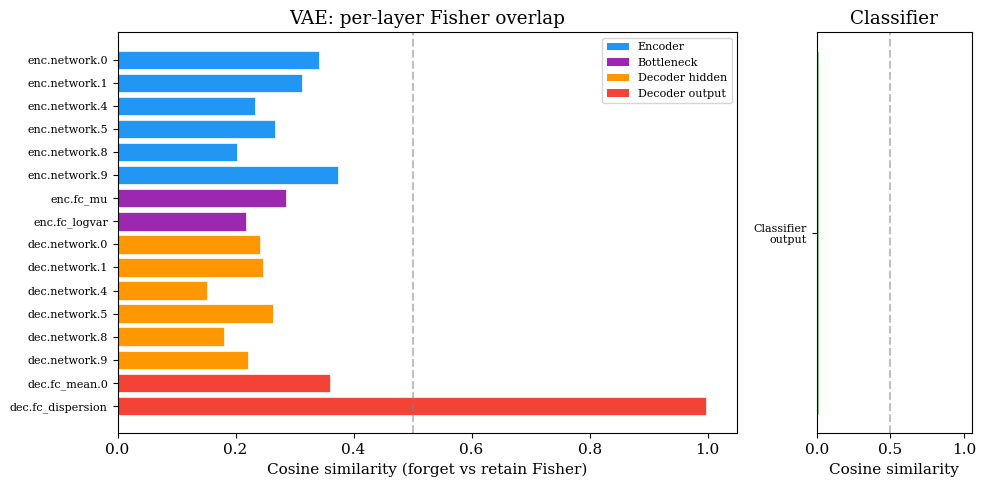

Saved to ../figures/fisher_overlap_layers.png


In [12]:
# Figure 1: Per-layer cosine similarity comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [4, 1]})

# VAE layers (left panel)
ax = axes[0]
weight_layers = [d for d in vae_layer_data if 'weight' in d['name'] and d['n_params'] > 100]
names = [d['name'].replace('encoder.', 'enc.').replace('decoder.', 'dec.').replace('.weight', '')
         for d in weight_layers]
cosines = [d['cosine'] for d in weight_layers]
cats = [d['category'] for d in weight_layers]

color_map = {'Encoder': '#2196F3', 'Bottleneck': '#9C27B0',
             'Decoder hidden': '#FF9800', 'Decoder output': '#F44336'}
colors = [color_map.get(c, '#999') for c in cats]

y_pos = range(len(names))
bars = ax.barh(y_pos, cosines, color=colors, edgecolor='white', linewidth=0.5)
ax.set_yticks(list(y_pos))
ax.set_yticklabels(names, fontsize=8)
ax.set_xlabel('Cosine similarity (forget vs retain Fisher)')
ax.set_title('VAE: per-layer Fisher overlap')
ax.set_xlim(0, 1.05)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
ax.invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=v, label=k) for k, v in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

# Classifier (right panel)
ax2 = axes[1]
clf_w = [d for d in clf_layer_data if 'weight' in d['name']]
clf_names = ['Classifier\noutput']
clf_cosines = [clf_w[0]['cosine']] if clf_w else [0]
ax2.barh([0], clf_cosines, color='#4CAF50', edgecolor='white')
ax2.set_yticks([0])
ax2.set_yticklabels(clf_names, fontsize=8)
ax2.set_xlabel('Cosine similarity')
ax2.set_title('Classifier')
ax2.set_xlim(0, 1.05)
ax2.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(FIGURES / 'fisher_overlap_layers.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {FIGURES / "fisher_overlap_layers.png"}')

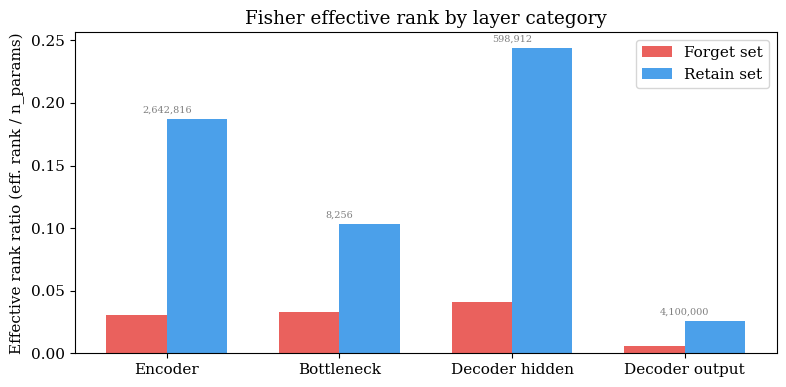

In [13]:
# Figure 2: Effective rank comparison
fig, ax = plt.subplots(figsize=(8, 4))

cat_names = ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output']
cat_colors = [color_map[c] for c in cat_names]

er_forget_by_cat = []
er_retain_by_cat = []
n_params_by_cat = []
for cat in cat_names:
    if cat in categories:
        ff_c = torch.cat(categories[cat]['f'])
        fr_c = torch.cat(categories[cat]['r'])
        er_forget_by_cat.append(effective_rank(ff_c) / len(ff_c))
        er_retain_by_cat.append(effective_rank(fr_c) / len(fr_c))
        n_params_by_cat.append(len(ff_c))

x = np.arange(len(cat_names))
w = 0.35
ax.bar(x - w/2, er_forget_by_cat, w, label='Forget set', color='#E53935', alpha=0.8)
ax.bar(x + w/2, er_retain_by_cat, w, label='Retain set', color='#1E88E5', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(cat_names)
ax.set_ylabel('Effective rank ratio (eff. rank / n_params)')
ax.set_title('Fisher effective rank by layer category')
ax.legend()

# Add param counts
for i, n in enumerate(n_params_by_cat):
    ax.text(i, max(er_forget_by_cat[i], er_retain_by_cat[i]) + 0.005,
            f'{n:,}', ha='center', fontsize=7, color='gray')

plt.tight_layout()
plt.savefig(FIGURES / 'fisher_effective_rank.png', dpi=150, bbox_inches='tight')
plt.show()

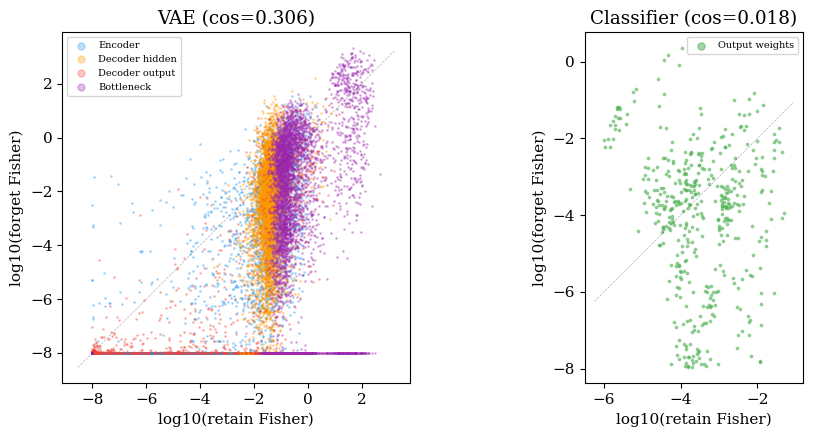

In [14]:
# Figure 3: Per-parameter scatter (log Fisher forget vs retain)
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

# VAE scatter
ax = axes[0]
np.random.seed(42)
for cat in ['Encoder', 'Decoder hidden', 'Decoder output', 'Bottleneck']:
    if cat not in categories:
        continue
    ff_c = torch.cat(categories[cat]['f']).numpy()
    fr_c = torch.cat(categories[cat]['r']).numpy()
    # Subsample for plotting
    n_plot = min(5000, len(ff_c))
    idx = np.random.choice(len(ff_c), n_plot, replace=False)
    ax.scatter(np.log10(fr_c[idx]), np.log10(ff_c[idx]),
              s=1, alpha=0.3, color=color_map[cat], label=cat, rasterized=True)

# Diagonal line
lims = [ax.get_xlim()[0], ax.get_xlim()[1]]
ax.plot(lims, lims, 'k--', alpha=0.3, linewidth=0.5)
ax.set_xlabel('log10(retain Fisher)')
ax.set_ylabel('log10(forget Fisher)')
ax.set_title(f'VAE (cos={vae_cos_global:.3f})')
ax.legend(fontsize=7, markerscale=5)
ax.set_aspect('equal')

# Classifier scatter
ax2 = axes[1]
for name in clf_fisher_forget:
    if 'weight' not in name:
        continue
    ff_c = clf_fisher_forget[name].flatten().numpy()
    fr_c = clf_fisher_retain[name].flatten().numpy()
    ax2.scatter(np.log10(fr_c), np.log10(ff_c),
               s=3, alpha=0.5, color='#4CAF50', label='Output weights', rasterized=True)

lims2 = [ax2.get_xlim()[0], ax2.get_xlim()[1]]
ax2.plot(lims2, lims2, 'k--', alpha=0.3, linewidth=0.5)
ax2.set_xlabel('log10(retain Fisher)')
ax2.set_ylabel('log10(forget Fisher)')
ax2.set_title(f'Classifier (cos={clf_cos_global:.3f})')
ax2.legend(fontsize=7, markerscale=3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.savefig(FIGURES / 'fisher_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Gene-level analysis

Which output genes drive the Fisher difference between forget and retain?

In [15]:
# For fc_mean, each row corresponds to one gene (2000 genes x 1024 hidden)
fc_mean_forget = fisher_forget['decoder.fc_mean.0.weight']  # [2000, 1024]
fc_mean_retain = fisher_retain['decoder.fc_mean.0.weight']  # [2000, 1024]

n_genes = fc_mean_forget.shape[0]
gene_cosines = []
gene_fisher_ratio = []

for g in range(n_genes):
    ff_g = fc_mean_forget[g]
    fr_g = fc_mean_retain[g]
    cos = cosine_sim(ff_g, fr_g)
    ratio = ff_g.sum().item() / fr_g.sum().item()
    gene_cosines.append(cos)
    gene_fisher_ratio.append(ratio)

gene_cosines = np.array(gene_cosines)
gene_fisher_ratio = np.array(gene_fisher_ratio)

print(f'Per-gene cosine similarity (fc_mean):')
print(f'  Mean: {gene_cosines.mean():.4f}')
print(f'  Median: {np.median(gene_cosines):.4f}')
print(f'  Std: {gene_cosines.std():.4f}')
print(f'  Min: {gene_cosines.min():.4f}')
print(f'  Max: {gene_cosines.max():.4f}')
print(f'  Genes with cos > 0.5: {(gene_cosines > 0.5).sum()} / {n_genes}')
print(f'  Genes with cos < 0.2: {(gene_cosines < 0.2).sum()} / {n_genes}')

Per-gene cosine similarity (fc_mean):
  Mean: 0.7360
  Median: 0.8769
  Std: 0.3099
  Min: 0.0211
  Max: 1.0000
  Genes with cos > 0.5: 1462 / 2000
  Genes with cos < 0.2: 142 / 2000


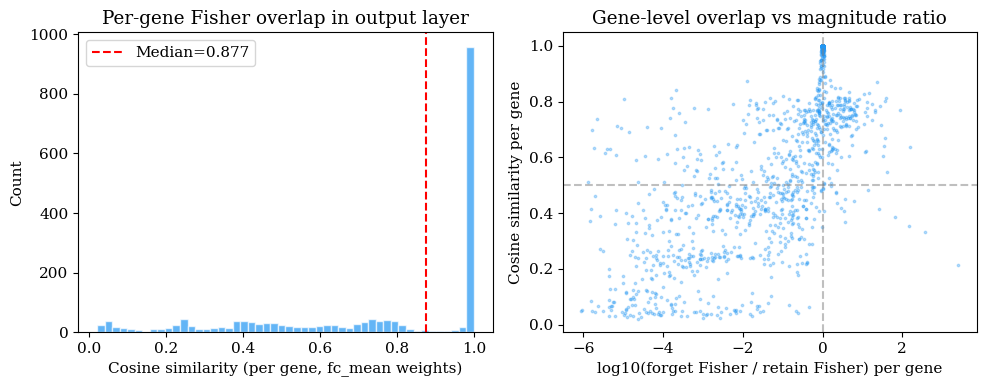

In [16]:
# Figure 4: Per-gene Fisher overlap distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram of per-gene cosine similarities
ax = axes[0]
ax.hist(gene_cosines, bins=50, color='#2196F3', alpha=0.7, edgecolor='white')
ax.axvline(x=np.median(gene_cosines), color='red', linestyle='--',
           label=f'Median={np.median(gene_cosines):.3f}')
ax.set_xlabel('Cosine similarity (per gene, fc_mean weights)')
ax.set_ylabel('Count')
ax.set_title('Per-gene Fisher overlap in output layer')
ax.legend()

# Fisher magnitude ratio vs cosine
ax2 = axes[1]
ax2.scatter(np.log10(gene_fisher_ratio), gene_cosines,
            s=3, alpha=0.3, color='#2196F3', rasterized=True)
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('log10(forget Fisher / retain Fisher) per gene')
ax2.set_ylabel('Cosine similarity per gene')
ax2.set_title('Gene-level overlap vs magnitude ratio')

plt.tight_layout()
plt.savefig(FIGURES / 'fisher_gene_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Save all results

In [17]:
results = {
    'vae': {
        'global_cosine': vae_cos_global,
        'global_eff_rank_forget': effective_rank(ff_global),
        'global_eff_rank_retain': effective_rank(fr_global),
        'total_params': len(ff_global),
        'log_fisher_correlation': torch.corrcoef(
            torch.stack([ff_global.log(), fr_global.log()])
        )[0,1].item(),
        'top_1pct_overlap': top_k_overlap(ff_global, fr_global, int(0.01*len(ff_global))),
        'top_10pct_overlap': top_k_overlap(ff_global, fr_global, int(0.1*len(ff_global))),
        'per_category': {},
        'per_layer': vae_layer_data,
    },
    'classifier': {
        'global_cosine': clf_cos_global,
        'total_params': len(ff_clf),
        'n_classes': n_classes,
        'per_layer': clf_layer_data,
    },
    'gene_analysis': {
        'mean_cosine': float(gene_cosines.mean()),
        'median_cosine': float(np.median(gene_cosines)),
        'std_cosine': float(gene_cosines.std()),
        'n_genes_cos_gt_0.5': int((gene_cosines > 0.5).sum()),
        'n_genes_cos_lt_0.2': int((gene_cosines < 0.2).sum()),
        'n_genes_total': n_genes,
    },
    'metadata': {
        'n_forget': len(forget_idx),
        'n_retain': len(retain_idx),
        'damping': 1e-8,
    },
}

# Add category-level metrics
for cat in ['Encoder', 'Bottleneck', 'Decoder hidden', 'Decoder output']:
    if cat in categories:
        ff_c = torch.cat(categories[cat]['f'])
        fr_c = torch.cat(categories[cat]['r'])
        results['vae']['per_category'][cat] = {
            'cosine': cosine_sim(ff_c, fr_c),
            'n_params': len(ff_c),
            'eff_rank_ratio_forget': effective_rank(ff_c) / len(ff_c),
            'eff_rank_ratio_retain': effective_rank(fr_c) / len(fr_c),
        }

with open(OUTPUTS / 'p6' / 'fisher_overlap_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=float)

print('Results saved to outputs/p6/fisher_overlap_results.json')
print()
print('=== Summary ===')
print(f'VAE global cosine:        {vae_cos_global:.4f}')
print(f'Classifier global cosine: {clf_cos_global:.4f}')
print(f'Ratio:                    {vae_cos_global/max(clf_cos_global, 1e-10):.2f}x')
print(f'VAE log-Fisher corr:      {results["vae"]["log_fisher_correlation"]:.4f}')
print(f'Gene-level median cosine: {results["gene_analysis"]["median_cosine"]:.4f}')

Results saved to outputs/p6/fisher_overlap_results.json

=== Summary ===
VAE global cosine:        0.3058
Classifier global cosine: 0.0181
Ratio:                    16.92x
VAE log-Fisher corr:      0.7274
Gene-level median cosine: 0.8769


## 10. Analysis and interpretation

### Summary of results

The global cosine similarity between forget-set and retain-set Fisher diagonals
is 0.306: the two sets share roughly 30% directional overlap in parameter importance.
The log-Fisher correlation is 0.727. Parameters important for the forget set are also
important for the retain set. Even the top-1% most important parameters overlap 20.5%
between the two sets, and top-10% overlap reaches 49.6%.

The decoder output layer has the highest overlap. The decoder output (`fc_mean`,
`fc_dispersion`) has a category-level cosine of 0.362 and accounts for 56% of all
parameters (4.1M of 7.35M). Within this category, `fc_dispersion` has cosine 0.998
because dispersion parameters are trained via MSE on all cells regardless of cell
type. `fc_mean` (the reconstruction weights) has cosine 0.360, because all 2000
output genes share the same weight matrix.

A logistic regression on frozen VAE latents (14 classes, 462 parameters, 93.7%
accuracy) has global cosine similarity of 0.018 between forget-class and retain-class
Fisher, 17x lower than the VAE. The forget class (cluster 13, megakaryocytes)
concentrates its Fisher information in the 32 output weights for that class, which
are orthogonal to the weights used by the 13 retain classes.

At the gene level, examining `fc_mean` row-by-row (one row per output gene), 1462 of
2000 genes (73%) have cosine similarity > 0.5 between forget and retain Fisher. The
median per-gene cosine is 0.877. Only 142 genes (7%) have cosine below 0.2, so even
the most "forget-specific" genes share substantial Fisher mass with the retain set.

### Figure descriptions

**Figure 1 (fisher_overlap_layers.png):** Per-layer cosine similarity for VAE weight
matrices (left) and the classifier output layer (right). VAE layers range from 0.15
(decoder hidden) to 0.36 (decoder output), all well above the classifier's 0.018.
The encoder first layer (0.34) and decoder output (0.36) are the highest. These
layers read from and write to the full 2000-gene space, so overlap there is expected.

**Figure 2 (fisher_effective_rank.png):** Effective rank ratio (effective rank /
parameter count) by layer category. The forget-set Fisher has lower effective rank
than the retain-set Fisher in all categories; the forget set's 30 cells concentrate
their gradient signal on fewer parameters. The decoder output has the lowest effective
rank ratio for the forget set (0.006 vs 0.010 for retain), yet still has the highest
cosine overlap. The concentrated forget-set signal still lands on parameters the
retain set also uses.

**Figure 3 (fisher_scatter.png):** Log-log scatter of per-parameter Fisher values
(retain vs forget). The VAE panel (left) shows a strong positive correlation (points
cluster along the diagonal), especially for decoder output parameters (red). The
classifier panel (right) shows no correlation: forget-class Fisher is concentrated
on a few parameters (high y-values) that have low retain-class Fisher (low x-values),
and vice versa. This is the structural difference that makes selective parameter
perturbation feasible for classifiers but not for VAEs.

**Figure 4 (fisher_gene_analysis.png):** Left: histogram of per-gene cosine
similarities in `fc_mean`. The distribution is heavily left-skewed with median 0.877;
most genes have nearly identical Fisher directions for forget and retain. Right:
scatter of per-gene Fisher magnitude ratio vs cosine similarity. Genes with high
forget/retain Fisher ratio (right side) tend to have lower cosine, but even these
outlier genes rarely fall below 0.2.

### Implications for unlearning

This overlap is consistent with the failure of all tested parameter-space unlearning
methods. Fisher scrubbing, SSD, gradient ascent, and retain fine-tuning all modify
parameters based on some estimate of forget-set importance. But because the VAE's
forget-set Fisher overlaps with the retain-set Fisher (cosine 0.306 globally, 0.362
in the decoder output), any perturbation large enough to reduce memorization of the
forget set also damages reconstruction of the retain set. The trade-off has no good
resolution: perturb too little and the forget set remains detectable; perturb too much
and the model degrades on all data.

The classifier comparison shows this is a structural property of the architecture,
not a limitation of the methods themselves. In a classifier, forget-class Fisher
concentrates in class-specific output weights (cosine 0.018), so perturbation can be
selective. In the VAE, all cell types share the same decoder weights, so selectivity
is impossible without architectural changes (e.g., cell-type-specific decoder heads).